In [1]:
# Importando dependências

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
from sklearn.tree import DecisionTreeRegressor  
import math
import os
! pip install patool
import patoolib

You should consider upgrading via the 'c:\users\felipe catapano\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [2]:
# Descomprimindo arquivo .rar e lendo o dataset
try:
    patoolib.extract_archive("vehicles.rar", outdir=os.getcwd())
    os.remove("vehicles.rar")
except:
    pass
Dataset = pd.read_csv('vehicles.csv')
Dataset = Dataset.iloc[28: , :]
Dataset.head(10)

patool: Extracting vehicles.rar ...
patool: running "C:\Program Files\WinRAR\rar.EXE" x -- "c:\Users\Felipe Catapano\Documents\GitHub\Car-Resell-Price-Predictor\vehicles.rar"
patool:     with cwd="c:\Users\Felipe Catapano\Documents\GitHub\Car-Resell-Price-Predictor"
patool: ... vehicles.rar extracted to `c:\Users\Felipe Catapano\Documents\GitHub\Car-Resell-Price-Predictor'.


,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
28,7316814758,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,...,NaN,pickup,blue,https://images.craigslist.org/00R0R_lwWjXSEWNa...,Carvana is the safer way to buy a car During t...,NaN,al,32.5900,-85.480000,2021-05-04T12:31:08-0500
29,7316814989,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,...,NaN,pickup,red,https://images.craigslist.org/01212_jjirIWa0y0...,Carvana is the safer way to buy a car During t...,NaN,al,32.5900,-85.480000,2021-05-04T12:31:25-0500
30,7316743432,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,...,NaN,pickup,red,https://images.craigslist.org/00x0x_1y9kIOzGCF...,Carvana is the safer way to buy a car During t...,NaN,al,32.5900,-85.480000,2021-05-04T10:41:31-0500
31,7316356412,https://auburn.craigslist.org/cto/d/auburn-uni...,auburn,https://auburn.craigslist.org,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,...,full-size,truck,black,https://images.craigslist.org/00404_l4loxHvdQe...,2013 F-150 XLT V6 4 Door. Good condition. Leve...,NaN,al,32.5920,-85.518900,2021-05-03T14:02:03-0500
32,7316343444,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,27990,2012.0,gmc,sierra 2500 hd extended cab,good,8 cylinders,...,NaN,pickup,black,https://images.craigslist.org/00V0V_ftJbKrOgdi...,Carvana is the safer way to buy a car During t...,NaN,al,32.5900,-85.480000,2021-05-03T13:41:25-0500
33,7316304717,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,34590,2016.0,chevrolet,silverado 1500 double,good,6 cylinders,...,NaN,pickup,silver,https://images.craigslist.org/00E0E_iKN07Sh7ou...,Carvana is the safer way to buy a car During t...,NaN,al,32.5900,-85.480000,2021-05-03T12:41:33-0500
34,7316285779,https://auburn.craigslist.org/cto/d/auburn-201...,auburn,https://auburn.craigslist.org,35000,2019.0,toyota,tacoma,excellent,6 cylinders,...,NaN,truck,grey,https://images.craigslist.org/00101_dXoZTH7iVm...,Selling my 2019 Toyota Tacoma TRD Off Road Dou...,NaN,al,32.6013,-85.443974,2021-05-03T12:12:59-0500
35,7316257769,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,29990,2016.0,chevrolet,colorado extended cab,good,6 cylinders,...,NaN,pickup,red,https://images.craigslist.org/00N0N_1xMPvfxRAI...,Carvana is the safer way to buy a car During t...,NaN,al,32.5900,-85.480000,2021-05-03T11:31:14-0500
36,7316133914,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,38590,2011.0,chevrolet,corvette grand sport,good,8 cylinders,...,NaN,other,red,https://images.craigslist.org/00U0U_kKYnS1LWh8...,Carvana is the safer way to buy a car During t...,NaN,al,32.5900,-85.480000,2021-05-03T07:50:35-0500
37,7316130053,https://auburn.craigslist.org/cto/d/opelika-19...,auburn,https://auburn.craigslist.org,4500,1992.0,jeep,cherokee,excellent,6 cylinders,...,NaN,NaN,NaN,https://images.craigslist.org/01010_7EM2aot64G...,192k miles brand new TSLs 4x4 jeep xj. 4x4 wor...,NaN,al,32.6454,-85.378300,2021-05-03T07:38:05-0500


# Quanto vale seu carro usado no Craigslist?

### A partir da análise de Dataset como quilometragem, ano do modelo, estado de conservação, tipo de combustível, entre outros, pretendemos prever o preço de revenda de um carro na plataforma Craigslist.   

In [3]:
# Remoção de outliers: Removeremos todas as linhas que tenham um preço com Z score(Número de desvios padrão
# de distância da média) maior ou igual a 3

z_scores = stats.zscore(Dataset.price)
abs_z = np.abs(z_scores)
Dataset['sigma'] = abs_z

Dataset = Dataset.loc[Dataset.sigma < 3,:]



# Análise exploratória -- Preços

Preço é a variável target do modelo. Assim, é de interesse analisar quais são os fatores fundamentais que influenciam em seu valor. Nesse sentido, através de gráficos de dispersão, histogramas e outras ferramentas estatísticas, determinaremos as features a serem consideradas.

In [4]:
#Criando função que facilita a plotagem de vários

def PlotVariosHist(bins, target, unidade_target, feature, feature_string, valores):
    plt.figure(figsize=(20,30))
    for valor in valores:
        plt.subplot(321+valores.index(valor))
        plt.hist(Dataset.loc[feature == valor][target], bins, edgecolor='white',density=True)
        plt.title("Densidade da frequência de {} quando {} é {}".format(target, feature_string, valor))
        plt.xlabel("{}, em {}".format(target, unidade_target))
        plt.ylabel("Densidade")
    plt.show()

clean         0.967701
rebuilt       0.017245
salvage       0.009240
lien          0.003397
missing       0.001944
parts only    0.000473
Name: title_status, dtype: float64


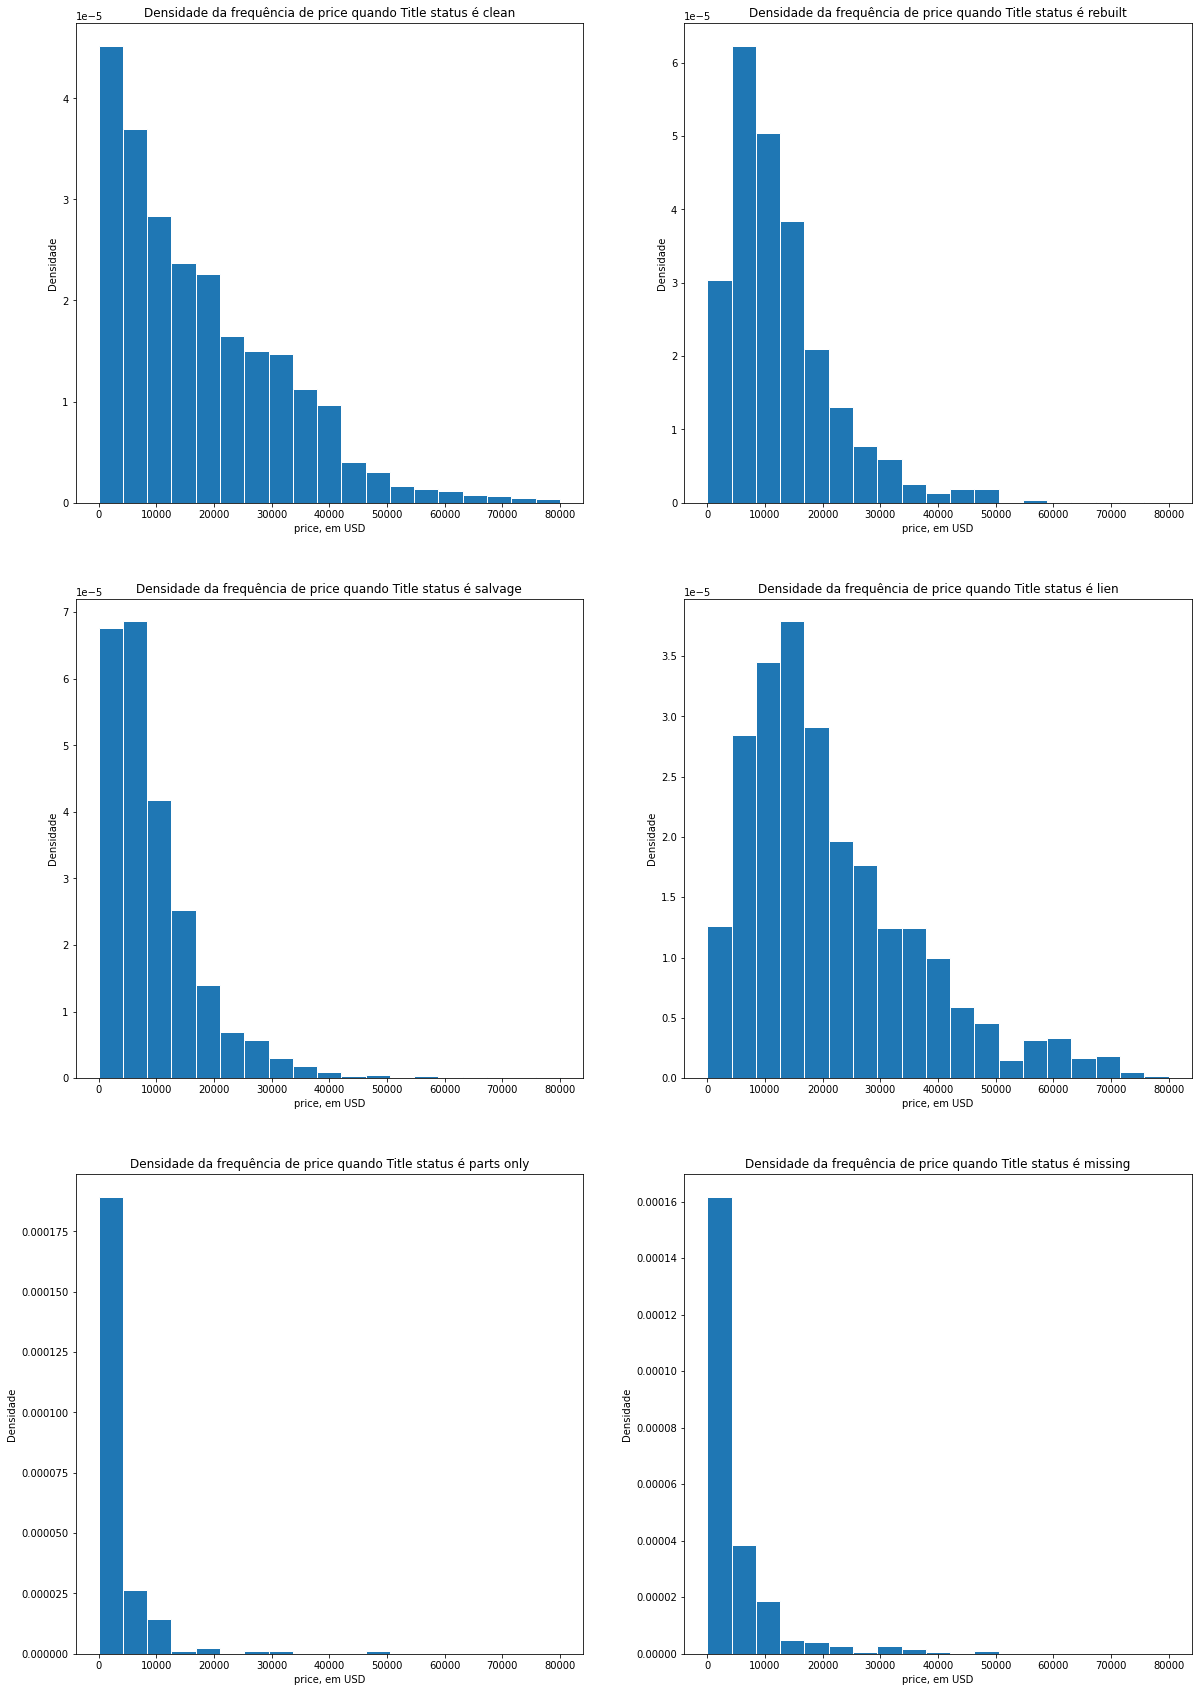

In [5]:
# Primeiramente, devemos decidir quais são as condições que o modelo assume. Imaginamos que venda de peças de carros
# ou de carros com peças faltando são casos significativamente diferentes do que a de um carro convencional. 

print(Dataset.title_status.value_counts(normalize=True))

# Para observar as diferenças:

PlotVariosHist(np.linspace(0,8e+4,20), 'price', 'USD', Dataset.title_status, 'Title status', ['clean', 'rebuilt', 'salvage', 'lien', 'parts only', 'missing'])

# Conclusão inicial:

Percebe-se que os preços de peças, carros com peça faltando e em más condições destoam bastante do convencional por praticamente não serem vendidos à valores mais altos. Já no caso de carros "com juros" (car lien é a venda de um carro em parcelas, na qual o vendedor cobra juros por segurança, podendo recuperar o carro caso não seja pago), eles costumam ter valores maiores que carros convencionais. Para carros reconstruídos, eles não cotumam ser vendidos por preços muito baixos, mas tendem a ter preços menores que o convencional na maioria dos casosetting an array element with a sequence.

A maioria dos carros convencionais são vendidos por preços abaixo de 20000 dólares e nota-se, portanto, que a densidade de veículos diminui com o aumento de preços.

count    393894.000000
mean      18902.138014
std       15398.367877
min           1.000000
25%        7000.000000
50%       15000.000000
75%       27590.000000
max      470000.000000
Name: price, dtype: float64


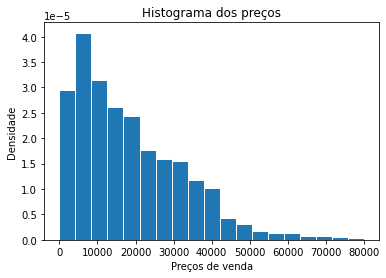

In [6]:
#Retirando preços excepcionais (nulos ou acima de 500000 dólares)
Dataset = Dataset.loc[Dataset['price'] > 0]
Dataset = Dataset.loc[Dataset['price'] < 0.5*(10**6)]

# Histograma de preços 

# Valores de interesse para basear as faixas
print(Dataset.price.describe())


plt.hist(Dataset.price,bins=np.linspace(0,8e+4,20),edgecolor='white',density=True)
plt.title('Histograma dos preços')
plt.xlabel('Preços de venda')
plt.ylabel('Densidade')
plt.show()

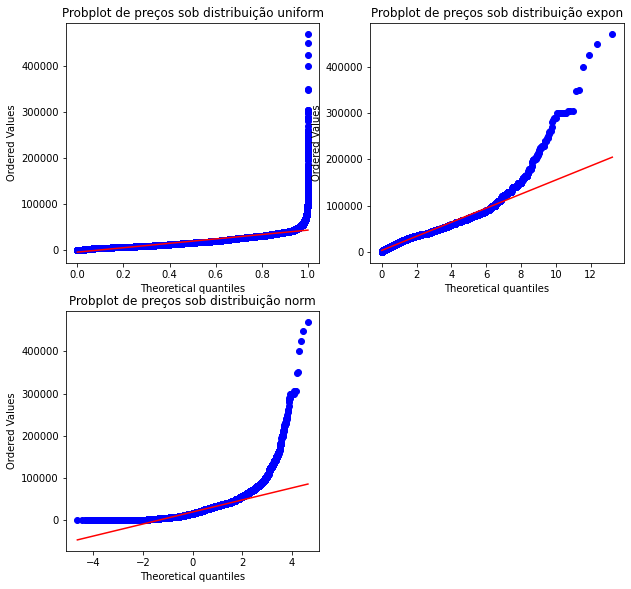

In [10]:
# A distribuição probabilística da variável target se assemelha, quase em sua totalidade com uma uniforme. 
# Para verificar temos que: 
distribuicoes = ['uniform', 'expon', 'norm']
plt.figure(figsize=(10,15))
for dist in distribuicoes:
    plt.subplot(321+distribuicoes.index(dist))
    stats.probplot(Dataset.price,dist=dist,plot=plt)
    plt.title("Probplot de preços sob distribuição {}".format(dist))
plt.show()

In [ ]:
# Kilometragem e preço são relacionados?

print("Correlação entre preço de carros e kilometragem: {}".format(Dataset.price.corr(Dataset.odometer)))

plt.scatter(Dataset.odometer,Dataset.price)
plt.title('Preço Vs Km')
plt.ylabel('Preço em dólar')
plt.xlabel('Kilometragem')
plt.show()

# Correlação bem fraca e negativa

In [ ]:
# Preço e condição se relacionam?

PlotVariosHist(np.linspace(0,8e+4,20), 'price', 'USD', Dataset.condition, 'Condition', ['good', 'excellent', 'like new', 'fair', 'new', 'salvage'])


## Conclusão -  condição

No caso da condição boa nota-se uma distribuição mais homogênea de preços, exceto para valores mais altos.
Contraintuitivamente para condições excelentes há maiores densidades de preços de valores mais baixos do que para condições boas. Entretanto, para valores no outro extremo há maiores densidades de preços no caso da condição excelente.
Para condições novas as densidades de preço caem com o aumento dos valores de venda, mas ainda há maiores densidades para valores altos do que no caso de condições nova e excelente.
Olhando para as condições mediana e recuperado percebe-se que apresentam comportamento bastante semelhante de valores muito mais altos de densidades para preços (muito) baixos.
Finalmente, o comportamento dos preços da condição similar a novo assemelha-se ao da condição novo em relação à diminuição de densidade à medida que o preço aumenta. Entretanto, a condição similar a novo apresenta densidades significativamente maiores para preços médios e altos.

In [ ]:
# Preço e tipo de câmbio se relacionam?

print(Dataset.transmission.value_counts(normalize=True))

PlotVariosHist(np.linspace(0,8e+4,20), 'price', 'USD', Dataset.transmission, 'Transmission', ['automatic', 'manual', 'other'])

# Percebe-se que carros automáticos e manuais tem uma distribuição relativamente parecida, diferentemente
# dos outros tipos, que destoam do padrão de preços.


## Conclusão - transmissão

A distribuição de preços de carros com câmbio automático e manual é bastante semelhante, no entanto, os automáticos apresentam densidades ligeiramente maiores em valores de venda mais altos.
No caso de outros tipos de transmissão, a distribuição de preços assemelha-se com uma distribuição normal, apresentando maiores densidades para valores medianos.

In [ ]:
# Preço e ano de fabricação se relacionam?

print("A correlação entre preço e ano, nos Dataset filtrados, é: {}".format(Dataset.price.corr(Dataset.year)))
plt.scatter(Dataset.year,Dataset.price)
plt.show()

# Associação fraca e positiva

## Variáveis dummy

Para trabalhar com modelos de regressão com variáveis quantitativas no target e qualitativas como features deve-se tratar as últimas como variáveis dummy. Isso significa que para cada uma das colunas de variáveis qualitativas serão criadas novas colunas para cada possível valor que a variável pode assumir. Caso uma linha apresente determinado valor, ela recebe '1' em sua respectiva coluna. Caso contrário, '0'.

Uma questão a ser considerada é a armadilha das variáveis dummies. Isso se refere à criação de variáveis de mais de uma coluna para valores que poderiam ser resumidos por uma só, a exemplo, 'sim' ou 'não'. Ser da categoria 'sim' implica em não ser da categoria 'não'. No caso, nossas categorias não possuem essa propriedade: ser da cor cinza não implica em ser da cor branca, uma vez que existem outras várias cores. Por isso não usamos a propriedade 'drop_first' para formar os dummies já que a perda da categoria inicial excluiria um perfil único por inteiro.

In [ ]:
dum = pd.get_dummies(Dataset, drop_first=False, columns=['year', 'title_status', 'condition', 'transmission', 'cylinders', 'fuel', 'type', 'paint_color', 'manufacturer', 'drive', 'size'])

X = dum.iloc[:, 25:]

results = sm.OLS(dum.price, X).fit()

results.summary()

## Regressão linear

A regressão linear é um procedimento matemático que, dada uma série de valores, encontra a reta que melhor sintetiza o comportamento desses dados e que pode ser usada para extrapolar novos valores. O método de regressão utilizado foi o Método dos Mínimos Quadrados, que encontra a reta cuja diferença dos quadrados dos valores da série e da função é mínima.

O coeficiente de determinação (também chamado de R^2) mostra quanto os valores da reta aproximam-se da realidade, sendo que quanto mais próximo de 1, mais fidedigno é o resultado.

Em nosso caso, o valor desse coeficiente (R-squared) = 0.831, o que indica que é significativamente próximo à realidade.

In [ ]:
regressor = DecisionTreeRegressor(random_state = 0) 
regressor.fit(X, dum.price)
score = regressor.score(X, dum.price)
score

## Regressão de árvore de decisão

Árvores de decisão são um método que tem como objetivo criar um modelo para prever o valor de uma variável target ao aprender regras de decisão da série de dados das features. No caso da biblioteca utilizada o regeressor monta a melhor curva seno possível para aproximar uma regra no modelo if/else. Com quanto mais variáveis features (justificadas) o modelo for alimentado, maior será o número de ramificações, que aumentará a complexidade das regras e tornará o modelo mais confiável.

Bem como na regressão linear, deverão ser utilizadas variáveis dummy para trabalhar quantitativamente com variáveis qualitativas.

In [ ]:
#ano title_status condition transmission cylinders fuel type paint_color manufacturer drive size

def predictor(year, title_status, condition, transmission, cylinders, fuel, body_type, paint_color, manufacturer, drive, size):
    
    lista = []
    ano_checado = False
    status_checado = False
    condicao_checado = False
    transmissao_checado = False
    cilindros_checado = False
    combustivel_checado = False
    tipo_checado = False
    tinta_checado = False
    montadora_checado = False
    tracao_checado = False
    tamanho_checado = False


    
    for ano in X.columns[:103]:
        if year in ano:
            lista.append(1)
            ano_checado = True
        else:
            lista.append(0)
    
    
    for status in X.columns[103:109]:
        if title_status in status:
            lista.append(1)
            status_checado = True
        else:
            lista.append(0)
    
    for condicao in X.columns[109:115]:
        if condition in condicao:
            lista.append(1)
            condicao_checado = True
        else:
            lista.append(0)
            
    for transmissao in X.columns[115:118]:
        if transmission in transmissao:
            lista.append(1)
            transmissao_checado = True
        else:
            lista.append(0)
            
    for cilindros in X.columns[118:126]:
        if cylinders in cilindros:
            lista.append(1)
            cilindros_checado = True
        else:
            lista.append(0)
            
    for combustivel in X.columns[126:131]:
        if fuel in combustivel:
            lista.append(1)
            combustivel_checado = True
        else:
            lista.append(0)
            
    for tipo in X.columns[131:144]:
        if body_type == 'van' and tipo == 'type_van':
            lista.append(1)
            tipo_checado = True
        elif body_type in tipo:
            lista.append(1)
            tipo_checado = True
        else:
            lista.append(0)
            
    for tinta in X.columns[144:156]:
        if paint_color in tinta:
            lista.append(1)
            tinta_checado = True
        else:
            lista.append(0)
    
    for montadora in X.columns[156:199]:
        if manufacturer in montadora:
            lista.append(1)
            montadora_checado = True
        else:
            lista.append(0)
    
    for tracao in X.columns[199:201]:
        if drive in tracao:
            lista.append(1)
            tracao_checado = True
        else:
            lista.append(0)
    
    for tamanho in X.columns[201:]:
        if size == 'compact' and tamanho == 'size_compact':
            lista.append(1)
            tamanho_checado = True
        elif size in tamanho:
            lista.append(1)
            tamanho_checado = True
        else:
            lista.append(0)
    
    print([ano_checado, status_checado, condicao_checado, transmissao_checado, cilindros_checado, combustivel_checado, tipo_checado, tinta_checado, montadora_checado, tracao_checado, tamanho_checado])
    
    if any([ano_checado, status_checado, condicao_checado, transmissao_checado, cilindros_checado, combustivel_checado, tipo_checado, tinta_checado, montadora_checado, tracao_checado, tamanho_checado])==False:
        return ('input invalido')
            
    return regressor.predict([lista]), results.predict(lista)
    


In [ ]:
#print(Dataset['year'].values)

#print(X.columns.to_frame())
print(len(X.columns))
print(X.iloc[:, 204].name)

In [ ]:
teste_tree, teste_linear = predictor('2020', 'clean', 'fair', 'manual', '8', 'gas', 'sedan', 'black', 'volkswagen', 'fwd', 'compact')

print(teste_tree, teste_linear)

In [ ]:
# Validação cruzada

for linha in Dataset.sample(10).values:
    preco = linha.price
    filtrado = linha.iloc[:,25:]
    reg_tree = regressor.predict([filtrado])
    reg_linear = results.predict(filtrado)
    print(f'Preço real: {preco}. Preço calculado pela regressão linear: {reg_linear}. Preço calculado pela regressão de árvore de decisão: {reg_tree}.')
    
    